# Computational Graphs with PyTorch
PyTorch is a toolkit for working with computational graphs and performing backpropagation in them via automatic computation of gradients. Therefore, PyTorch is a great starting point for NNs and – once one surpasses the basics – is a good base for producing well-designed and structured, object-oriented neural network code.

This notebook consolidates my ideas (in an executable form) for teaching neural networks (including the very basics) in Python and with PyTorch.

The following is organized as follows:
* a very basic computational graph with minimal loss computation, backpropagation of error and gradient descent *without PyTorch*
* the same but now using PyTorch
* the same but based on `torch.nn.Module`


In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [2]:
# we will often repeatedly use some code for plotting. We define this once to be re-used later.
def plot(plot_data):
    # plt.xkcd()
    plt.figure("evolution over training iterations")
    for type in plot_data.keys():
        data = plot_data[type]
        if None in data:
            plt.plot(data, 'o', label=type)
        else:
            plt.plot(data, label=type)
    plt.legend(loc='best')

## A very basic computational graph (not even a neural network). 

Even simple neural networks, even a single neuron is more complicated than what we need to get started. So we simplify:

The idea is that we have a parameter (our estimate) and a target that we want to match. Note that in typical applications, we also have inputs (which we don't have here) and many different target values and that the model is to understand the relation between inputs and target values. Below, we show a single neuron on the left, and what we intend to achieve on the right.

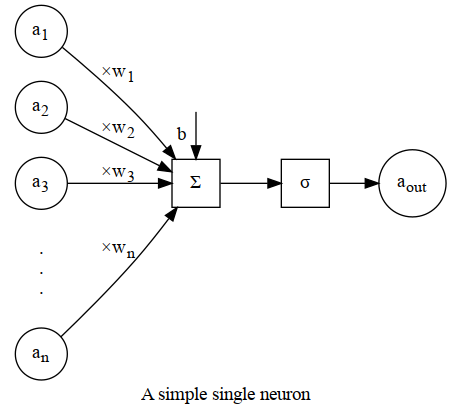 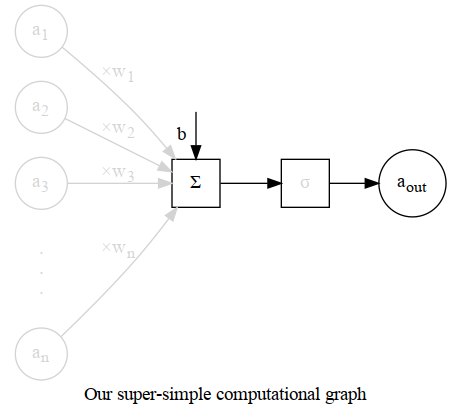

We compute the error of the model as the quadratic loss between model estimate and target. We then backpropagate the error to the (only) parameter. We then update the parameter using gradient descent (with a learning rate of, say, 0.1). We repeat this process 100 times. (That's the whole idea of gradient descent: take a small step in the right direction and repeat, until you have taken many steps.) Estimate, target and quadratic error are displayed below.

It may be interesting to check for differences when varying the learning rate. 

Also, the code as-is assumes that the target signal is always "perfect" at 5.0. Uncomment the line that sets target to roughly 5 (adding Gaussian noise) and check the influence on your results.

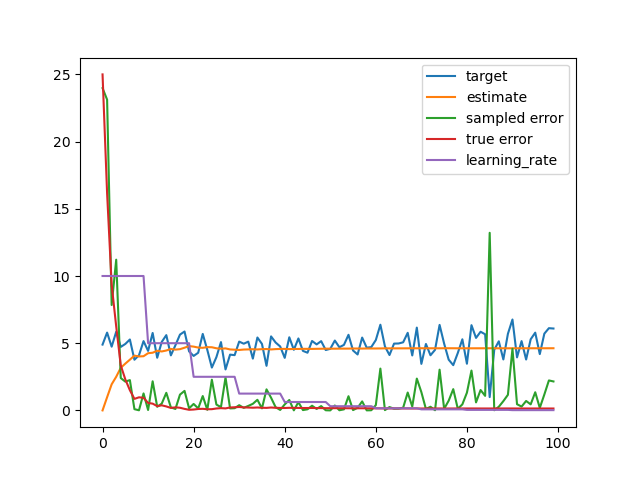

In [3]:
# how about a minimal example: 
# We have one input (let's fix it to 5?) and one parameter. 
# The goal is to use gradient descent to minimize the squared difference between parameter and input. 
# possible extension: add some noise to the input
%matplotlib widget
true_target = 5.
target = true_target
noise_level = 1.
estimate = 0.

learning_rate = 0.1 # when we "learn", we do not want to take only a small step into the right direction, instead of forgetting all our beliefs from before
plot_data = defaultdict(lambda : [])

def loss(estimate, target):
    '''
    very standard quadratic loss. 
    by taking the square, we neglect small errors and amplify large errors
    (and we automatically neglect the sign of the error)
    '''
    return (target - estimate) ** 2

def gradient_of_loss_wrt_estimate(estimate, target):
    '''
    computes how the loss changes when the estimate changes
    This is the derivative of the loss function
    '''
    return 2 * (target - estimate)

# in gradient descent, we take many small steps (here: 100) and repeatedly change 
# the estimate according to the derivative of the parameters wrt to the error 
# using a small learning rate (which increases the number of steps necessary but 
# makes learning more robust to noise). 
# an alternative to a predetermined number of steps is checking performance on held-out
# data and stopping after no improvements occur, or stopping once the loss stops to improve.
for iteration in range(100):
    target = random.normalvariate(true_target, noise_level) # this version varies the input (what you get with "data" drawn from some underlying distribution
    error = loss(estimate, target)
    plot_data["target"].append(target)
    plot_data["estimate"].append(estimate)
    plot_data["sampled error"].append(error)
    plot_data["true error"].append(loss(estimate, true_target))
    derivative_of_error = gradient_of_loss_wrt_estimate(estimate, target)
    estimate += learning_rate * derivative_of_error # gradient descent!
    if (iteration > 0 and iteration % 10 == 0):
        learning_rate /= 2 
    plot_data["learning_rate"].append(learning_rate * 100)

plot(plot_data)

The example above is "pure python", i.e., it doesn't use anything specific for training neural networks. 

Specifically, we use ```loss()``` to perform the **forward** computation, i.e, what we need when we apply our model. Then, ```gradient_of_loss_wrt_estimate()``` yields the result of our **backward** computation, the gradient of the loss wrt. all the different parameters of the model (lucky us, there's just one gradient as  ```estimate``` is the only parameter of the model). We use this gradient in the update rule for gradient descent.

You may want to experiment with the code above in the following ways:
* what happens if you increase the or reduce the learning rate? How about learning rates greater than 1 or smaller than 0? What happens at learning rates greater than .5?

<details>
    Of course, learning rates below zero steer us away from what we should learn; likewise, learning rates at 1 make us overshoot the target (and coud lead to oscillation) and values above 1 are likewise useless. However, note that values above .5 lead to an oscillation that eventually converges around the desired value; this is not necessarily bad. (However, in light of noisy data (next bullet point), very low learning rates are usually favorable. Do play with the learning rate settings also for the next bullet points.
</details>

* instead of using a fixed target, add some spice to it: uncomment the line ```target = random.normalvariate(5., 1.)```. What do you expect will happen?<br>
  Note that the introduction of random noise is similar to what we'll (later) experience in data-driven training: our data samples are never perfect representations of the underlying data distribution but there's always some error sampling involved.
* often, it can be helpful to adapt the learning rate during learning: in the beginning, when you're "clueless" you want to learn quickly, later it's better to not apply changes too quickly. Modify the code so that the learning rate is halved every 10 training iterations. Add code that plots your learning rate (or better: 100* the learning rate so that it becomes visible in the plot) Does this improve the learning performance? 

<details>
    within the loop add:<br>
<code>if iteration > 0 and iteration % 10 == 0:
&nbsp;&nbsp;&nbsp;&nbsp;learning_rate /= 2
plot_data['learning rate'].append(learning_rate * 100)</code></details>


## A computational graph with Torch.

In the next example, we automate the computation of gradients and the updating of the parameter. We do this by integrating **PyTorch** (or simply: *torch*) into the process:
* instead of defining our target and estimate as regular float values, we define them via torch (as `tensors`)
* torch already has a definition for our loss function, how convenient!
* what's exciting about torch is its ability to compute the gradient by itself based on the operations that the tensors are involved in. We don't need to worry about this at all! Instead, we simply call the `.backward()` on the loss that we want to compute the derivatives for.
* we also define an `optimizer` that is passed the learning rate. The optimizer uses the gradients stored with the parameter tensors so they can be updated. There is a multitude of optimizers, we'll use the most simple one (which does the same as our own implementation above).

The code now looks as follows.

In [4]:
import torch
# i tried this with Python 3.10 on Ubuntu 22.04 (im-kigs); PyTorch is 2.0.1 with CUDA 11.7

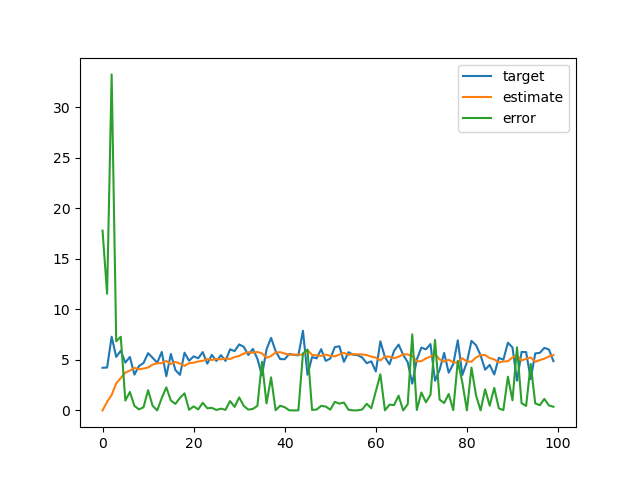

In [5]:
%matplotlib widget
target = torch.tensor([5.])
estimate = torch.tensor([0.], requires_grad = True)
learning_rate = 0.1
plot_data = defaultdict(lambda : [])

optimizer = torch.optim.SGD([estimate], lr = learning_rate)

#Instead of computing the loss ourselves, we can use torch's implementation of the same squared error loss:
loss = torch.nn.MSELoss() # this does the same as our own definition above

# no need to implement gradient_of_loss_wrt_estimate -- that's the true benefit of using PyTorch!

for iteration in range(100):
    target = torch.normal(true_target, noise_level, size=(1,)) # this version varies the input (what you get with "data" drawn from some underlying distribution
    error = loss(estimate, target)
    plot_data["target"].append(target.item())
    plot_data["estimate"].append(estimate.item())
    plot_data["error"].append(error.item())
    error.backward()
    optimizer.step() # run gradient descent for one step
    optimizer.zero_grad() # delete the gradient cache (otherwise prior gradients would still be considered in optimization and training would not succeed.

plot(plot_data)

You may want to experiment with the code above in the following ways:
* use the hand-written loss function from above instead of ```torch.nn.MSELoss()```. Does this work?

<details>
This works as before. In other words: you're free to mix operations that you implement yourself with those provided by PyTorch. We'll make extensive use of this in the future: first, we implement stuff ourselves, then I'll show you that it's already built-in in PyTorch (but then, you'll also know what the PyTorch version does under the hood).
</details>

* reflect on the data types used in loss(): in the pure-python solution, the inputs and the output were floats. What are they here? How come this still works?

<details>
Python is a <em>dynamically typed</em> language. We provide names for variables but not types. Types are determined at runtime and a variable may hold data of different types at different times. In other words: the types are part of the values but not part of the variables. When you now use our loss-function in the PyTorch context, both inputs are of type <tt>torch.tensor</tt>.<br>
Python has another interesting feature: <em>operator overloading</em>. Operator overloading does not exist in Java, therefore it might be new to you. In effect, you can write <tt>(target - estimate) ** 2</tt> even if target and estimate are not numeric types. However, target then must be an object which implements a pre-defined subtraction operation (<tt>__sub__</tt>; Java people may want to think of this as the class's object implementing an interface that defines the subtraction operation). For a tensor, the result of this operation is a new tensor that contains the difference of the two operands. That tensor (like all other tensors) also has a <tt>__pow__</tt>-operation which can take as argument another tensor, a float or an int (as in our case) and yields a new tensor with the appropriate value. <br>
Operator overloading is a great feature without which neural network code would be very hard to read. (Our formula would have to be written in Java as <tt>target.sub(estimate).pow(2)</tt> or similarly, which can easily become more difficult to read than the plain formula.)
</details>

* strategies for updating parameters are plentiful, see https://pytorch.org/docs/stable/optim.html. Check what happens when you replace SGD with Adam or RMSprop.

More realistic models than ours above have very many parameters and elaborate computations to come to an estimate (which is then scored with the loss function against some target). Typically, there is also some *structure* to the parameters and computations and therefore it is useful to organize these into modules that can be combined into ever larger neural network models.

PyTorch uses object-oriented programming for organizing large neural networks. A network extends the class `torch.nn.Module` which can contain its own parameters (as below) or use its own sub-modules. 

Below, we first implement a very basic module (to show the pattern) and later we will implement modules for simple tasks that we will gradually combine into more complex modules. (Often, we will first implement a module for some aspect and only afterwards show you the equivalent implementation that already exists in PyTorch.)

## An extremely basic `torch.nn.Module`.
This does the same as the code above but it uses the mechanism for PyTorch [*modules*](https://pytorch.org/docs/stable/notes/modules.html) out of which multi-layered neural networks can be built (and which then themselves are also modules):
* a module is a class that extends ```torch.nn.Module```
* the constructor calls the super-constructor (this doesn't happen automatically in Python, let's take a moment to praise Java!), and initializes whatever it needs to initialize (in our case: the estimate tensor)
* we register our estimate variable as a ```torch.nn.Parameter``` (which extends ```torch.tensor```) which registers it in the module as something that can be changed via gradient descent. (Btw., this uses reflection under the hood: the module's ```parameters()``` function searches all the instance variables, checks for their type and returns a ist of all parameters. Java people would certainly do this differently.)
* we implement a specific ```forward``` function that performs whatever computation that we deem necessary. In our case nothing beyond providing the single parameter.
* Now PyTorch takes over: we can call the module (as it has implemented the special operation ```__eval__```) and this will call our ```forward``` computation and will take note of what parameters are involved (and in which way) in the computations, so that it can later determine the gradient computation, when we call ```error.backward()```. (Note that we call the backward operation on the value for which we want to know the gradients, i.e., how the value changes with changes in the parameters.)
* The optimizer then updates our module's parameters as before.

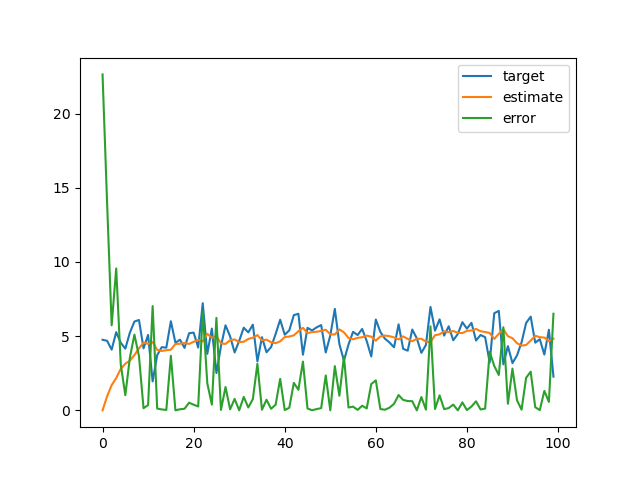

In [6]:
%matplotlib widget
learning_rate = 0.1
target = torch.tensor([5.])

class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.estimate = torch.nn.Parameter(torch.zeros(1))
    def forward(self) -> torch.Tensor:
        return self.estimate

plot_data = defaultdict(lambda : [])

tinynet = TinyNet()
optimizer = torch.optim.SGD(tinynet.parameters(), lr = learning_rate)
loss = torch.nn.MSELoss()

## the remainder of this cell is the same as the code example above.
for _ in range(100):
    target = torch.normal(true_target, noise_level, size=(1,))
    estimate = tinynet() # call the module
    error = loss(estimate, target)
    error.backward()
    plot_data["target"].append(target.item())
    plot_data["estimate"].append(tinynet.estimate.item())
    plot_data["error"].append(error.item())
    optimizer.step()
    optimizer.zero_grad()

plot(plot_data)

okay, now we have used a module but why is it better? The answer is: for what we've done, it makes little difference. However, when models become more complex, the modular way enables us to plug larger NN-models together from smaller sub-modules. See e.g. our introductory code on [MNIST](MNISTbasic.ipynb) and even more the stuff [afterwards](MNISTadvanced.ipynb).